# Figures for Canine Sarcomas Data
Dataset can be downloaded from https://www.ebi.ac.uk/pride/archive/projects/PXD010990 and paper from https://doi.org/10.1016/j.ccell.2018.09.009.

## Preparation

In [4]:
import os,csv,random
import pandas as pd
import numpy as np
import scanpy as sc
import math

from skimage import io, color
import torch

In [5]:
from scanpy import read_10x_h5
import SpaGCN as spg
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import pickle

In [6]:
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.metadata import Metadata

In [7]:
%cd /Users/anjideng1/Desktop/MALDI

/Users/anjideng1/Desktop/MALDI


In [8]:
import sys
sys.path.append('/Users/anjideng1/Desktop/MALDI/MALDI_package')

import MALDI_package as MALDIpy
MALDIpy.__version__

'1.0.0'

## Reading Data
import Ds1, (2), 3, 4, 18, 19, 20, 24, (26) (normal)

In [9]:
file_loc = '/Users/anjideng1/Desktop/MALDI/data/CanineSarcomas'

In [ ]:
MALDIdataAnn_cancer = sc.read_h5ad(filename  = file_loc + "/CanineSarcomas_Ds2_05.h5ad") # change here
MALDIdataAnn_normal = sc.read_h5ad(filename  = file_loc + "/CanineSarcomas_Ds26_05.h5ad")

In [7]:
MALDIdataAnn_cancer = sc.read_h5ad(filename  = file_loc + "/CanineSarcomas_Ds2_05.h5ad") # change here
MALDIdataAnn_normal = sc.read_h5ad(filename  = file_loc + "/CanineSarcomas_Ds26_05.h5ad")

MALDIdataAnn_cancer.obs = MALDIdataAnn_cancer.obs.astype(int)
sc.pp.normalize_per_cell(MALDIdataAnn_cancer)

MALDIdataAnn_normal.obs = MALDIdataAnn_normal.obs.astype(int)
sc.pp.normalize_per_cell(MALDIdataAnn_normal)

## Plots of m/z shift

In [129]:
PeakGroup = MALDIpy.PeakCalling(MALDIdataAnn_cancer, MALDIdataAnn_normal)
PeakGroup.callpeak(0.9)
PeakGroup.grouppeaks(0.9)

In [130]:
ExactAlign = MALDIpy.AnnDataMALDI(MALDIdataAnn_cancer, MALDIdataAnn_normal)
ExactAlign.get_corr_peakgroup_refined(PeakGroup.jointcluster)
ExactAlign.greedy_match()
ExactAlign.fine_align(threshould = 0.2, ignore = True)

100%|██████████| 99/99 [00:00<00:00, 1009.84it/s]


In [131]:
ExactAlign.summarize()

In [132]:
aligned_index_normal = ExactAlign.referenalign

In [133]:
aligned_index_cancer = ExactAlign.unknownalign

In [13]:
shift = []

for i in tqdm(range(len(MALDIdataAnn_normal.var))):
    if i in aligned_index_normal:
        index_aligned = int(np.where(aligned_index_normal == i)[0]) # find the index of i in 'aligned_index_cancer'
        index = aligned_index_cancer[index_aligned] # find the aligned cancer index in mz values
        d = float(MALDIdataAnn_cancer.var_names[index]) - float(MALDIdataAnn_normal.var_names[i])
        shift.append(d)
    else:
        shift.append(0.0)

100%|██████████| 3800/3800 [00:00<00:00, 51915.28it/s]


In [14]:
shift_dic = {'mzvalues': MALDIdataAnn_cancer.var_names,
         'shift': shift}
df_shift = pd.DataFrame(shift_dic)
df_shift.reset_index(drop=True, inplace=True)

In [15]:
csv_file_path = '/Users/anjideng1/Desktop/MALDI/output'

In [16]:
df_shift.to_csv(csv_file_path + '/shift_ds2_par3.csv', index = False)

Text(0.5, 1.0, 'Ds2')

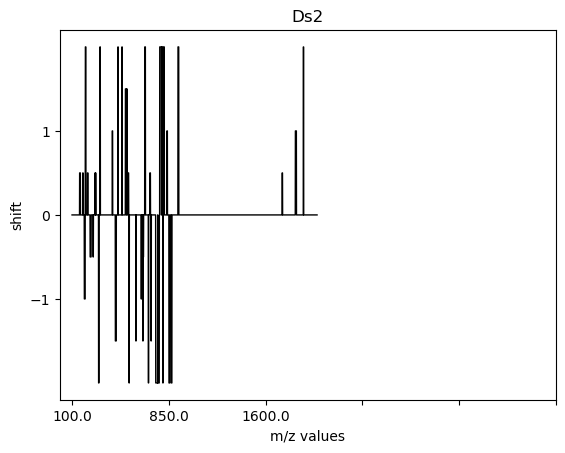

In [17]:
plt.plot(MALDIdataAnn_normal.var_names, shift, linewidth = 1, label = 'Difference', color = 'black')
plt.xlabel('m/z values')
plt.ylabel('shift')
plt.xticks(np.arange(0, 9000, 1500))
plt.yticks([-1, 0, 1])
plt.title('Ds2')

### Using code from MALDI package

In [8]:
PeakGroup = MALDIpy.PeakCalling(MALDIdataAnn_cancer, MALDIdataAnn_normal)
PeakGroup.callpeak(0.9)
PeakGroup.grouppeaks(0.9)

In [9]:
ExactAlign = MALDIpy.AnnDataMALDI(MALDIdataAnn_cancer, MALDIdataAnn_normal)
ExactAlign.get_corr_peakgroup_refined(PeakGroup.jointcluster)
ExactAlign.greedy_match()
ExactAlign.fine_align(threshould = 0.2, ignore = True)
ExactAlign.summarize()

100%|██████████| 99/99 [00:00<00:00, 904.02it/s]


In [10]:
## Shifting distribution plot
SD = MALDIpy.MALDI_SIM(ExactAlign)
file_loc = '/Users/anjideng1/Desktop/MALDI/'
SD.shiftdatadf.to_csv("output/new_shift/mzshifting_Ds2_par3.csv", sep = ",")

100%|██████████| 99/99 [00:00<00:00, 6225.24it/s]


## Plots of Pearson's Coefficient

In [8]:
import seaborn as sns

In [9]:
PeakGroup = MALDIpy.PeakCalling(MALDIdataAnn_cancer, MALDIdataAnn_normal)
PeakGroup.callpeak(0.9)
PeakGroup.grouppeaks(0.9)

In [10]:
sum(PeakGroup.peakRef)

535

In [11]:
sum(PeakGroup.peakUnk)

471

In [12]:
ExactAlign = MALDIpy.AnnDataMALDI(MALDIdataAnn_cancer, MALDIdataAnn_normal)
ExactAlign.get_corr_peakgroup_refined(PeakGroup.jointcluster)
ExactAlign.greedy_match()
ExactAlign.fine_align(threshould = 0.2, ignore = True)

100%|██████████| 99/99 [00:00<00:00, 516.66it/s]


In [13]:
len(PeakGroup.jointcluster)

99

In [16]:
# PeakGroup.jointcluster

In [17]:
ExactAlign.PearsonMatrixFull

array([[0.97922121, 0.59108106, 0.23853978, ..., 0.        , 0.        ,
        0.        ],
       [0.69973372, 0.97571218, 0.57445422, ..., 0.        , 0.        ,
        0.        ],
       [0.45239819, 0.6852588 , 0.97137689, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.98521367, 0.60331786,
        0.39251656],
       [0.        , 0.        , 0.        , ..., 0.73621224, 0.9918283 ,
        0.66574061],
       [0.        , 0.        , 0.        , ..., 0.49117705, 0.75902773,
        0.99373626]])

In [28]:
num_rows, num_columns = ExactAlign.PearsonMatrixFull.shape
print(f"Number of lists (rows): {num_rows}")
print(f"Number of elements in each list (columns): {num_columns}")
# There are 99 clusters, slide each cluster from -4 to 4.

Number of lists (rows): 891
Number of elements in each list (columns): 891


In [49]:
len(ExactAlign.PearsonMatrixFull)

891

In [50]:
ExactAlign.nclusters

99

In [21]:
# np.apply_along_axis(len, axis = 1, arr = ExactAlign.PearsonMatrixFull)

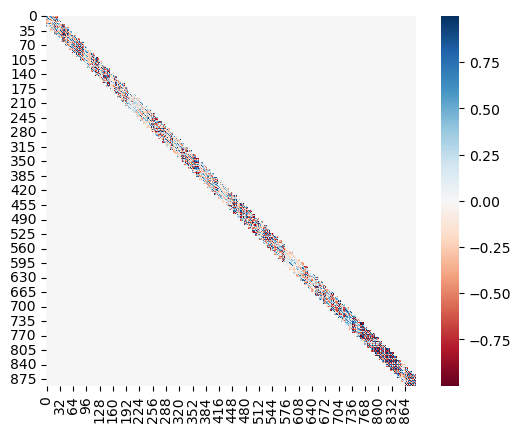

In [22]:
sns.heatmap(ExactAlign.PearsonMatrixFull, cmap = 'RdBu', square = True)
plt.show()

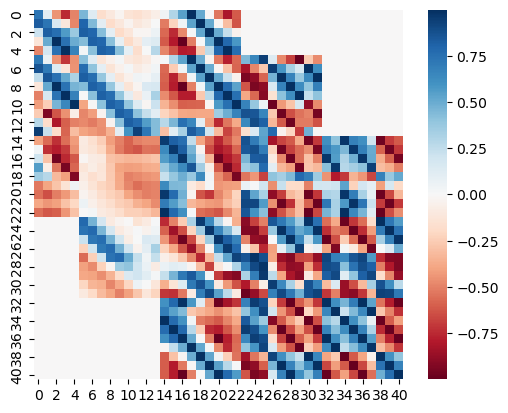

In [24]:
sns.heatmap(ExactAlign.PearsonMatrixFull[850:900, 850:900], cmap = 'RdBu', square = True)
plt.show()
# 850 - 900, top left

In [14]:
PeakGroup.jointcluster[94]

[1729.0, 1729.5, 1730.0, 1730.5, 1731.0]

In [53]:
# ExactAlign.mz_valueRef.iloc[ExactAlign.aligned_mz_clusters_ref[94]]

In [20]:
PeakGroup.jointcluster[7]

[203.5, 204.0, 204.5, 205.0, 205.5, 206.0, 206.5]

In [55]:
# ExactAlign.mz_valueRef.iloc[ExactAlign.aligned_mz_clusters_ref[7]]

In [ ]:
# ExactAlign.mz_valueRef.iloc[ExactAlign.aligned_mz_clusters_ref[43]]

,m/z
522.5,522.5
523.0,523.0
523.5,523.5
524.0,524.0
524.5,524.5
525.0,525.0
525.5,525.5
526.0,526.0
526.5,526.5


In [35]:
from matplotlib.colors import LinearSegmentedColormap

# Define RGB values (0 to 255) for the red color
red_rgb = (150, 5, 5)

# Convert RGB values to the range expected by Matplotlib (0 to 1)
red_color = tuple(component / 255.0 for component in red_rgb)

# Define a custom colormap
colors = [red_color, 
          (1, 1, 1), 
          red_color]  # Red to white to red
custom_cmap = LinearSegmentedColormap.from_list('custom_red_white_red', colors, N=256)

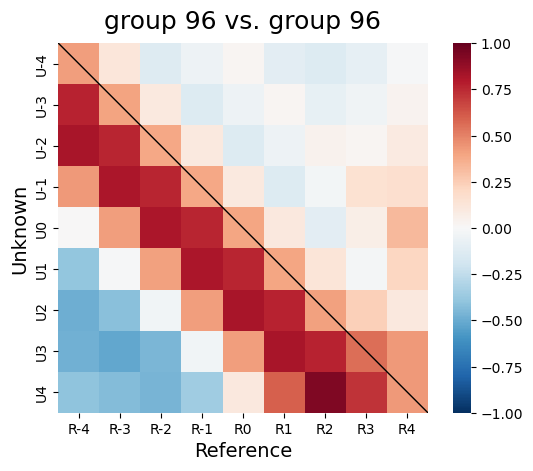

In [15]:
y_labels = ['U-4', 'U-3', 'U-2', 'U-1', 'U0', 'U1', 'U2', 'U3', 'U4']
x_labels = ['R-4', 'R-3', 'R-2', 'R-1', 'R0', 'R1', 'R2', 'R3', 'R4']

sns.heatmap(ExactAlign.PearsonMatrixFull[855:864, 855:864], cmap = 'RdBu_r', square = True,
            xticklabels = x_labels, yticklabels = y_labels, vmin = -1, vmax = 1)

plt.xlabel('Reference', fontsize = 14)
plt.ylabel('Unknown', fontsize = 14)
# 850 - 900, top left

# Create a y = -x line
x_values = np.arange(len(x_labels) + 1)
y_values = x_values
sns.lineplot(x = x_values, y = y_values, color = 'black', linestyle = '-', linewidth = 1)
plt.suptitle("group 96 vs. group 96", fontsize = 18, y = 0.95, x = 0.455)
plt.savefig('heatmap_grp96.png', dpi=300)  # Adjust the filename and dpi as needed
plt.show()

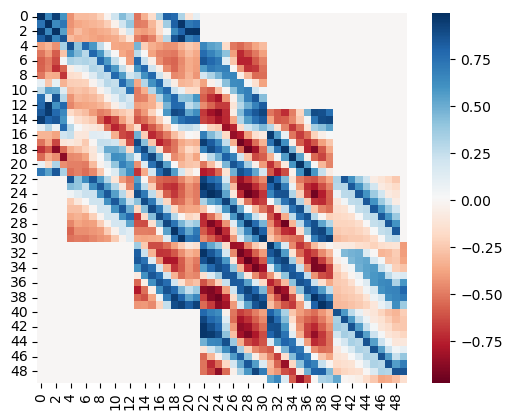

In [156]:
sns.heatmap(ExactAlign.PearsonMatrixFull[50:100, 50:100], cmap = 'RdBu', square = True)
plt.show()
# 50 - 100: top left

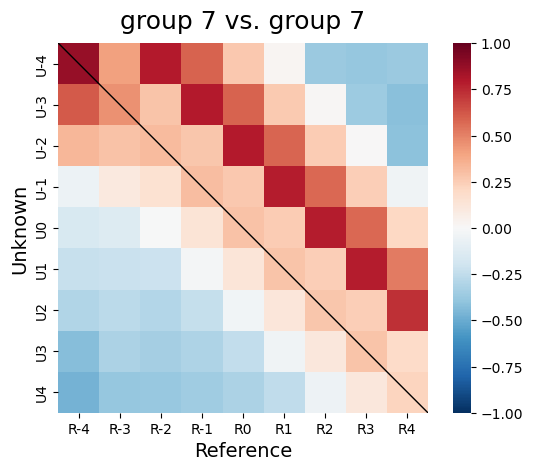

In [16]:
y_labels = ['U-4', 'U-3', 'U-2', 'U-1', 'U0', 'U1', 'U2', 'U3', 'U4']
x_labels = ['R-4', 'R-3', 'R-2', 'R-1', 'R0', 'R1', 'R2', 'R3', 'R4']

sns.heatmap(ExactAlign.PearsonMatrixFull[54:63, 54:63], cmap = 'RdBu_r', square = True,
            xticklabels = x_labels, yticklabels = y_labels, vmin = -1, vmax = 1)

plt.xlabel('Reference', fontsize = 14)
plt.ylabel('Unknown', fontsize = 14)

sns.lineplot(x = x_values, y = y_values, color = 'black', linestyle = '-', linewidth = 1)
plt.suptitle("group 7 vs. group 7", fontsize = 18, y = 0.95, x = 0.455)
plt.savefig('heatmap_grp7.png', dpi=300)
plt.show()
# 50 - 100: top left

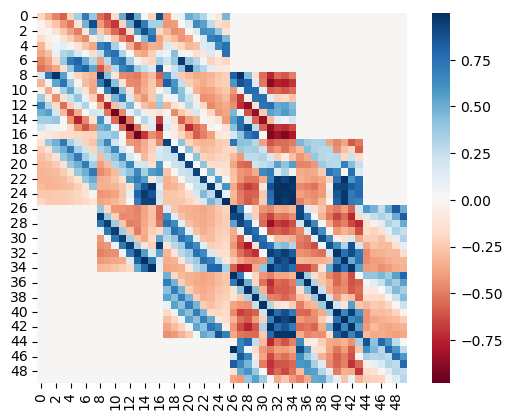

In [34]:
sns.heatmap(ExactAlign.PearsonMatrixFull[10:60, 10:60], cmap = 'RdBu', square = True)
plt.show()
# 10 - 60: left bottom

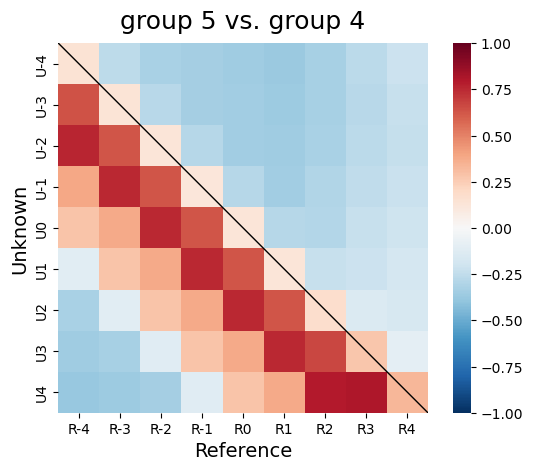

In [17]:
y_labels = ['U-4', 'U-3', 'U-2', 'U-1', 'U0', 'U1', 'U2', 'U3', 'U4']
x_labels = ['R-4', 'R-3', 'R-2', 'R-1', 'R0', 'R1', 'R2', 'R3', 'R4']

sns.heatmap(ExactAlign.PearsonMatrixFull[36:45, 27:36], cmap = 'RdBu_r', square = True,
            xticklabels = x_labels, yticklabels = y_labels, vmin = -1, vmax = 1)

plt.xlabel('Reference', fontsize = 14)
plt.ylabel('Unknown', fontsize = 14)

sns.lineplot(x = x_values, y = y_values, color = 'black', linestyle = '-', linewidth = 1)
plt.suptitle("group 5 vs. group 4", fontsize = 18, y = 0.95, x = 0.455)
plt.savefig('heatmap_grp5.png', dpi=300)
plt.show()
# 10 - 60: left bottom